# Bulk RNA-seq analysis

Yesterday we got started working on HPC, learning Unix commands, and running bash scripts. That is a lot to do in just a few hours, so we expect that today we will also be working on navigating the command line and aligning reads. We can answer questions and troubleshoot altogether if many people have similar questions, and/or some of us can break out into small groups to address specific questions.

There are a few more steps post-alignment we need to do in order to get our gene-by-sample counts matrices. We want to make sure to touch on everyone's interests as much as possible (and give you the tools needed to start thinking about your projects!), so we have pre-made counts matrices so we can get started on secondary analysis and plotting.

## STAR
### Quantify reads with RSEM
```
/pub/namvn1/COSMO/RNA_Seq/run_RSEM.sh
```

### Load counts matrix into R

## Kallisto
### Get gene-level abundance matrices

```
mkdir c2c12_rnaseq_timecourse/counts
cd c2c12_rnaseq_timecourse/mapped
for folder in *_*; do cp $folder/abundance.tsv ../counts/$folder.tsv; done
```

Counts:
```
python /pub/erebboah/cosmos/C2C12_bulkRNA_timecourse/scripts/abundanceToGene_estCounts.py c2c12 /pub/erebboah/cosmos/C2C12_bulkRNA_timecourse/ref/gencode.vM21.gene_transcripts.tab ../counts/
```

TPM:
```
python /pub/erebboah/cosmos/C2C12_bulkRNA_timecourse/scripts/abundanceToGene_TPM.py c2c12 /pub/erebboah/cosmos/C2C12_bulkRNA_timecourse/ref/gencode.vM21.gene_transcripts.tab ../counts/

mv c2c12.tpm.matrix.csv.gz ../counts
mv c2c12.counts.matrix.csv.gz ../counts
gunzip ../counts/*.gz
```

### Load TPM matrix into R

If you need them, copy the counts and TPM matrices from my public directory to your home directory:
```
cp /pub/erebboah/cosmos/C2C12_bulkRNA_timecourse/counts/c2c12.counts.matrix.csv .
cp /pub/erebboah/cosmos/C2C12_bulkRNA_timecourse/counts/c2c12.tpm.matrix.csv .
```

In [177]:
mat = as.matrix(read.csv("c2c12_rnaseq_timecourse/counts/c2c12.tpm.matrix.csv", row.names = 1))

In [178]:
head(mat)
dim(mat)

,Ctrl_0hr_A,Ctrl_0hr_B,Ctrl_0hr_C,Ctrl_12hr_A,Ctrl_12hr_B,Ctrl_12hr_C,Ctrl_24hr_A,Ctrl_24hr_C,Ctrl_48hr_A,Ctrl_48hr_B,...,FI_24hr_C,FI_48hr_A,FI_48hr_B,FI_48hr_C,FI_6hr_A,FI_6hr_B,FI_6hr_C,FI_72hr_A,FI_72hr_B,FI_72hr_C
ENSMUSG00000102693.1|4933401J01Rik,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000064842.1|Gm26206,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000051951.5|Xkr4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000102851.1|Gm18956,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000103377.1|Gm37180,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000104017.1|Gm37363,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


[1] 55450    35

We have 55,450 genes by 35 samples. The python script outputs both the Ensembl gene ID and the gene name separated by "|"; let's grab the gene name to be more human readable.

In [179]:
library(stringr)

In [180]:
gene_name = sapply(strsplit(rownames(mat), "[|]"), "[[", 2) # string manipulation using | as a separator
head(gene_name)

[1] "4933401J01Rik" "Gm26206"       "Xkr4"          "Gm18956"      
[5] "Gm37180"       "Gm37363"

In [181]:
rownames(mat) = gene_name
head(mat) # much better

,Ctrl_0hr_A,Ctrl_0hr_B,Ctrl_0hr_C,Ctrl_12hr_A,Ctrl_12hr_B,Ctrl_12hr_C,Ctrl_24hr_A,Ctrl_24hr_C,Ctrl_48hr_A,Ctrl_48hr_B,...,FI_24hr_C,FI_48hr_A,FI_48hr_B,FI_48hr_C,FI_6hr_A,FI_6hr_B,FI_6hr_C,FI_72hr_A,FI_72hr_B,FI_72hr_C
4933401J01Rik,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Gm26206,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Xkr4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Gm18956,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Gm37180,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Gm37363,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


55,450 genes sounds like a lot-- probably because many aren't expressed, such as predicted genes like Gm26206. We can filter out rows containing all 0 values using the `rowSums()` function.

In [182]:
mat = mat[rowSums(mat[])>0,]
dim(mat)

[1] 25240    35

### PCA and outlier removal

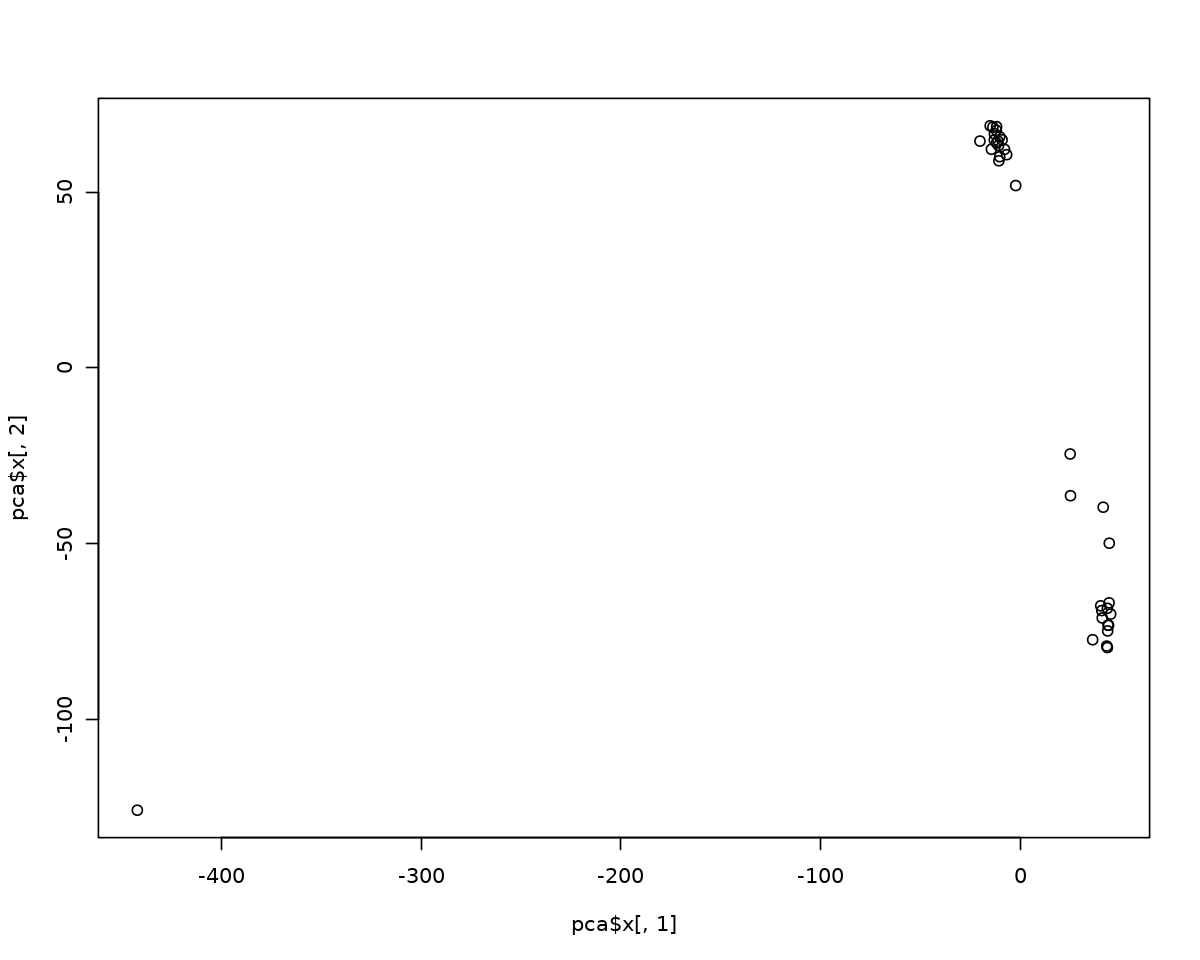

In [183]:
# Run PCA algorithm and plot
pca <- prcomp(t(log2(mat+1)))
plot(pca$x[,1], pca$x[,2])

We can make a fancier PCA plot with `ggplot`.

In [184]:
# Grab x from pca output
pca_out <- as.data.frame(pca$x)

# Get percent variance explained for x and y axes
percentage <- round(pca$sdev/sum(pca$sdev) * 100, 2)
percentage <- paste0(colnames(pca_out), " (", paste0(as.character(percentage), "%", ")"))

In [185]:
# Use column names and string manipulation to make metadata
pca_out$Timepoint <- sapply(strsplit(colnames(mat), "_"), "[[", 2)
pca_out$Timepoint <- as.numeric(substr(pca_out$Timepoint,1,nchar(pca_out$Timepoint)-2))
pca_out$Treatment <- sapply(strsplit(colnames(mat), "_"), "[[", 1)
pca_out$Sample <- colnames(mat)
pca_out$Replicate <- sapply(strsplit(colnames(mat), "_"), "[[", 3)

Warning message:
"ggrepel: 29 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


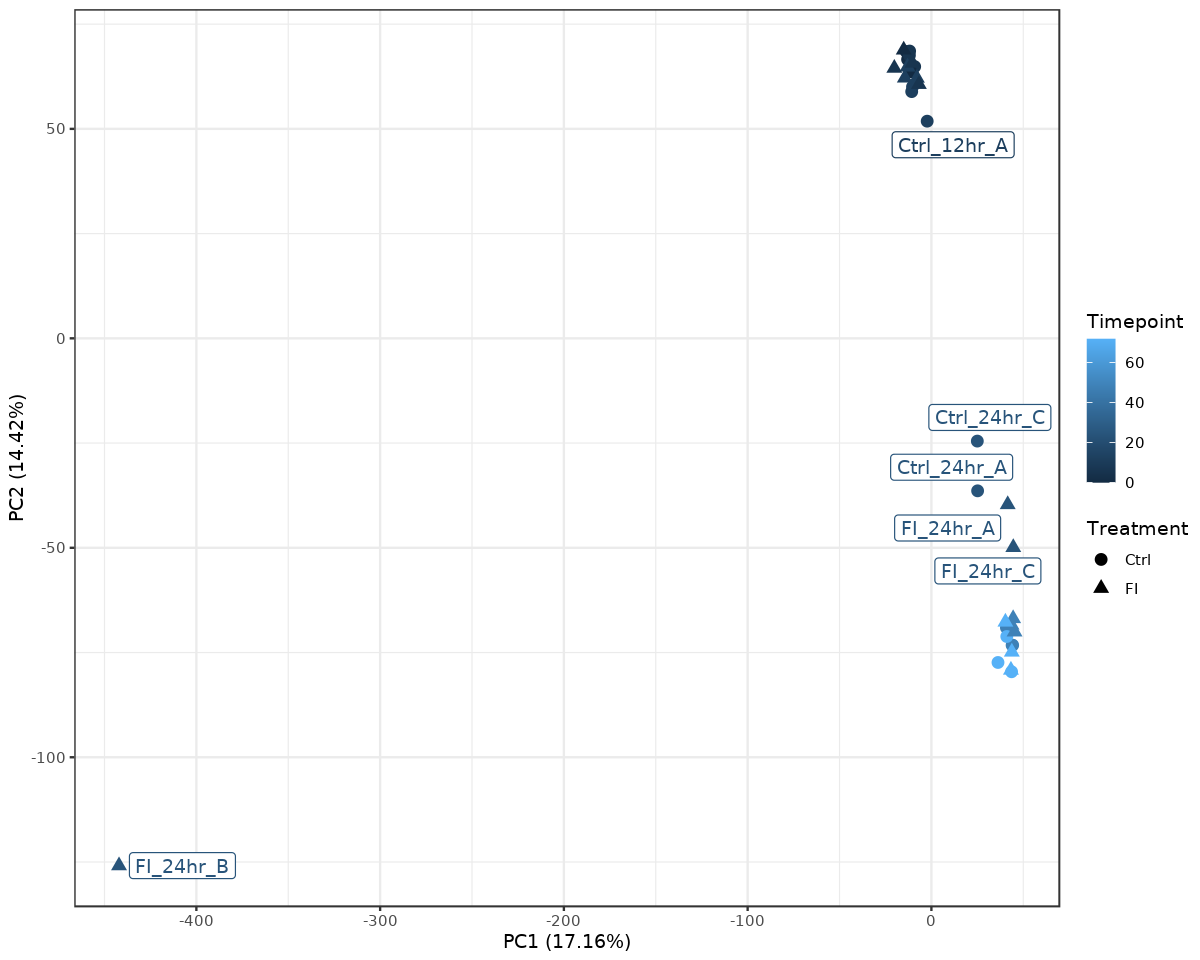

In [188]:
library(ggplot2)
library(ggrepel)

# Labels are sample, colors are timepoint
p = ggplot(pca_out,aes(x=PC1,y=PC2,color=Timepoint))+
  geom_point(aes(shape=Treatment),size=3) + 
  xlab(percentage[1]) + ylab(percentage[2]) +
  geom_label_repel(aes(label = Sample),
                   box.padding   = 0.35, 
                   point.padding = 0.5,
                   segment.color = 'grey50',
                   show.legend=FALSE) +
  theme_bw()
print(p)

Looks like FI_24hr_B is an outlier! You can also check the run_info.json file and notice that there were only 1.4% pseudoaligned reads. This library definitely failed sequencing and should be removed from the matrix. Luckily, we have 2 more replicates for this sample.

In [189]:
mat_filt = mat[,colnames(mat) != "FI_24hr_B"]
dim(mat_filt)

[1] 25240    34

Let's make another PCA plot but change the [colors](https://colorbrewer2.org/):

In [225]:

pca <- prcomp(t(log2(mat_filt+1)))
pca_out <- as.data.frame(pca$x)
percentage <- round(pca$sdev/sum(pca$sdev) * 100, 2)
percentage <- paste0(colnames(pca_out), " (", paste0(as.character(percentage), "%", ")"))
pca_out$Timepoint <- sapply(strsplit(colnames(mat_filt), "_"), "[[", 2)
pca_out$Timepoint <- as.numeric(substr(pca_out$Timepoint,1,nchar(pca_out$Timepoint)-2))
pca_out$Treatment <- sapply(strsplit(colnames(mat_filt), "_"), "[[", 1)
pca_out$Sample <- colnames(mat_filt)
pca_out$Replicate <- sapply(strsplit(colnames(mat_filt), "_"), "[[", 3)

# Change continuous timepoint scale to factor to mess around with more color palettes
pca_out$Timepoints <- factor(pca_out$Timepoint, levels=unique(sort(pca_out$Timepoint)))

p = ggplot(pca_out,aes(x=PC1,y=PC2,color=Timepoints))+
  geom_point(aes(shape=Treatment),size=3) + 
  xlab(percentage[1]) + ylab(percentage[2]) +
  geom_label_repel(aes(label = Sample), 
                   box.padding   = 0.35, 
                   point.padding = 0.5,
                   segment.color = 'grey50',
                   show.legend=FALSE) +
  theme_bw() + scale_color_brewer(palette="BuPu")

Warning message:
"ggrepel: 17 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


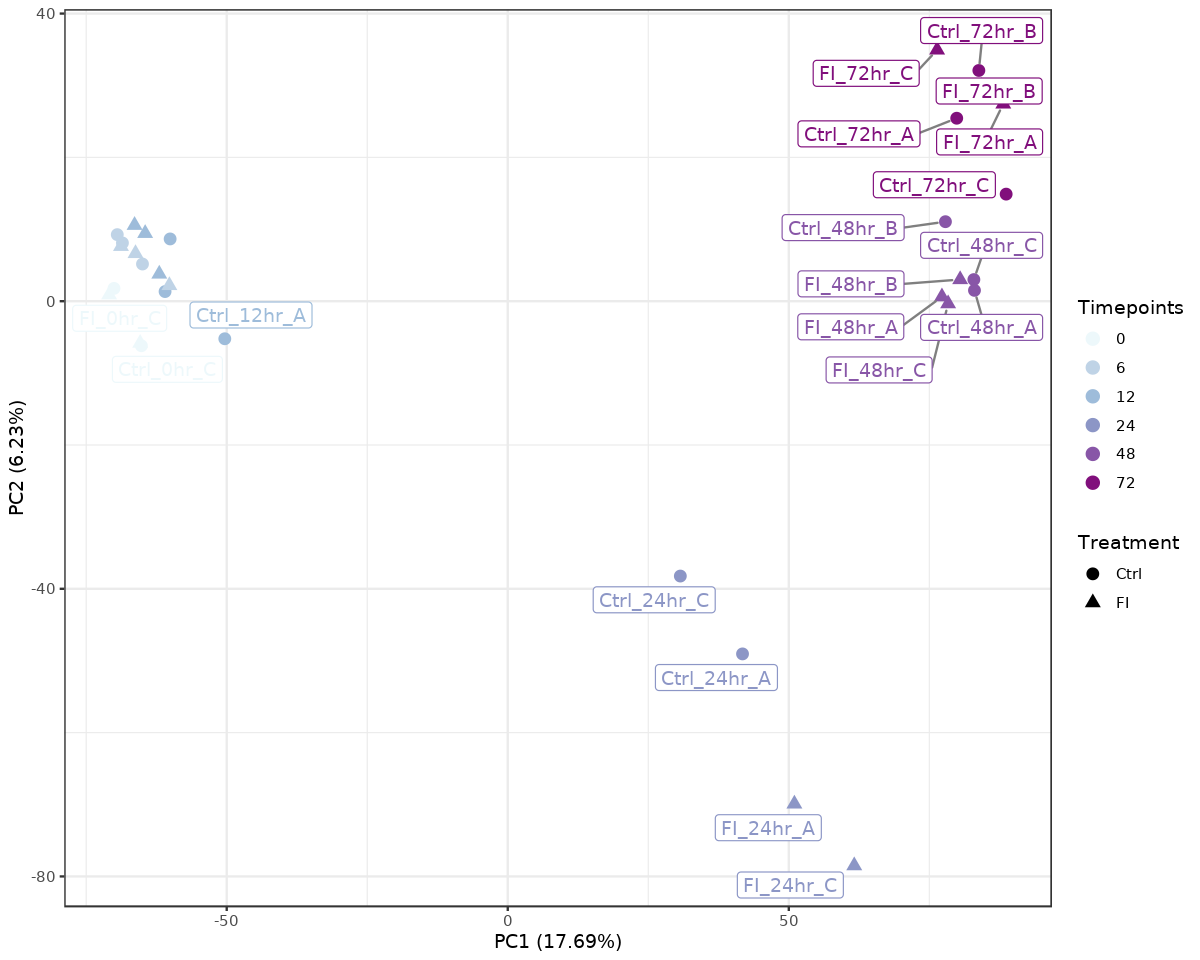

In [226]:
print(p)

Save figure to a PDF! Make a figures directory if you haven't done so:

In [123]:
system("mkdir c2c12_rnaseq_timecourse/figures")

In [131]:
pdf(file = "c2c12_rnaseq_timecourse/figures/PCA.pdf",
    width = 5.5, 
    height = 5)
print(p)
dev.off()

Warning message:
"ggrepel: 30 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


png 
  2

### Run differential expression analysis

In [227]:
library(edgeR)

In [273]:
# Input raw counts for edgeR
counts = as.matrix(read.csv("c2c12_rnaseq_timecourse/counts/c2c12.counts.matrix.csv", row.names = 1))

# Remove outlier
counts_filt = counts[,colnames(counts) != "FI_24hr_B"]
gene_name = sapply(strsplit(rownames(counts_filt), "[|]"), "[[", 2) # string manipulation using | as a separator
rownames(counts_filt) = gene_name

In [274]:
# We need a metadata file -- basically already made it earlier with stringsplit operations
meta = pca_out[,c("Sample","Timepoint","Treatment","Replicate")]
head(meta)

,Sample,Timepoint,Treatment,Replicate
,<chr>,<dbl>,<chr>,<chr>
Ctrl_0hr_A,Ctrl_0hr_A,0,Ctrl,A
Ctrl_0hr_B,Ctrl_0hr_B,0,Ctrl,B
Ctrl_0hr_C,Ctrl_0hr_C,0,Ctrl,C
Ctrl_12hr_A,Ctrl_12hr_A,12,Ctrl,A
Ctrl_12hr_B,Ctrl_12hr_B,12,Ctrl,B
Ctrl_12hr_C,Ctrl_12hr_C,12,Ctrl,C


In [275]:
meta$Treated = as.numeric(meta$Treatment == "FI")
meta$Treatment = NULL
meta$Sample = NULL
head(meta)

,Timepoint,Replicate,Treated
,<dbl>,<chr>,<dbl>
Ctrl_0hr_A,0,A,0
Ctrl_0hr_B,0,B,0
Ctrl_0hr_C,0,C,0
Ctrl_12hr_A,12,A,0
Ctrl_12hr_B,12,B,0
Ctrl_12hr_C,12,C,0


We will use [edgeR](https://www.bioconductor.org/packages/release/bioc/vignettes/edgeR/inst/doc/edgeRUsersGuide.pdf) to determine differentially expressed genes.

In [276]:
y <- DGEList(counts=counts_filt, group=factor(meta$Timepoint))

In [277]:
# Filter lowly expressed genes
keep <- filterByExpr(y)
y <- y[keep, , keep.lib.sizes=FALSE]
y <- calcNormFactors(y)
dim(y)

[1] 14938    34

In [291]:
# Make design matrix
design <- model.matrix(~Timepoint+Treated, data=meta)
head(design)

,(Intercept),Timepoint,Treated
Ctrl_0hr_A,1,0,0
Ctrl_0hr_B,1,0,0
Ctrl_0hr_C,1,0,0
Ctrl_12hr_A,1,12,0
Ctrl_12hr_B,1,12,0
Ctrl_12hr_C,1,12,0


In [349]:
# Estimate dispersions
y <- estimateDisp(y,design)

In [492]:
fit <- glmQLFit(y,design)
qlf <- glmQLFTest(fit,coef=2)
topTags(qlf)

,logFC,logCPM,F,PValue,FDR
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
S100a4,-0.05874641,8.922235,1129.8805,3.170763e-28,4.252907e-24
Reep6,0.07234360,4.491892,1094.8411,5.412545e-28,4.252907e-24
Syk,-0.07750491,3.469004,1047.6070,1.143252e-27,5.988734e-24
Gm28710,-0.19572539,2.773990,1017.2213,1.882053e-27,6.720272e-24
Stmn2,-0.08770961,7.299136,1009.5823,2.138171e-27,6.720272e-24
Chchd10,0.07525418,7.849762,864.4373,2.936388e-26,6.694202e-23
Dlx3,-0.07878792,3.201220,863.6490,2.981827e-26,6.694202e-23
Gm32856,0.05112260,2.988237,817.8015,7.460769e-26,1.465575e-22
Cntln,-0.04654737,5.419104,783.3442,1.536408e-25,2.682739e-22


In [495]:
# Top 10 genes (by p value) that are differentially expressed between timepoints:
head(qlf$table[order(qlf$table$PValue),])

,logFC,logCPM,F,PValue
,<dbl>,<dbl>,<dbl>,<dbl>
S100a4,-0.05874641,8.922235,1129.8805,3.170763e-28
Reep6,0.07234360,4.491892,1094.8411,5.412545e-28
Syk,-0.07750491,3.469004,1047.6070,1.143252e-27
Gm28710,-0.19572539,2.773990,1017.2213,1.882053e-27
Stmn2,-0.08770961,7.299136,1009.5823,2.138171e-27
Chchd10,0.07525418,7.849762,864.4373,2.936388e-26


In [496]:
qlf <- glmQLFTest(fit,coef=3)

# Top 10 genes (by p value) that are differentially expressed between fusion-inhibited and control:
head(qlf$table[order(qlf$table$PValue),])

# Upregulated in FI:
fi_up = qlf$table[qlf$table$logFC > 0,]
head(fi_up[order(fi_up$PValue),])

,logFC,logCPM,F,PValue
,<dbl>,<dbl>,<dbl>,<dbl>
4930438A08Rik,-4.443706,1.1631232,111.19296,2.086525e-12
Spink5,-2.810884,-0.9079797,50.35131,2.880302e-08
Mt2,-1.057639,7.9757865,48.64287,4.129708e-08
Wnt11,-2.465713,-1.9043686,46.96172,5.931322e-08
Igfn1,-2.169474,2.1735305,43.16769,1.382274e-07
Gm36607,-1.786434,0.6987373,39.87898,2.981059e-07


,logFC,logCPM,F,PValue
,<dbl>,<dbl>,<dbl>,<dbl>
AI839979,1.665603,0.4379932,33.19939,1.592364e-06
Ces2c,1.906571,-0.1518918,32.07393,2.147733e-06
Sdf2l1,1.558662,6.2240912,25.99961,1.190412e-05
Tmem184a,1.348226,0.9175271,21.69475,4.493532e-05
Manf,1.084984,8.3142291,20.21689,7.273287e-05
Serpina12,1.950885,-0.4743808,20.12736,7.491991e-05


We can also perform exact tests between specific samples:

In [470]:
group = substr(colnames(counts_filt),1,nchar(colnames(counts_filt))-2)
y <- DGEList(counts=counts_filt, group=group)

keep <- filterByExpr(y) 
y <- y[keep, , keep.lib.sizes=FALSE]

y <- estimateDisp(y) 

Using classic mode.



In [471]:
et <- exactTest(y, pair=c("Ctrl_0hr","Ctrl_72hr"))

# order by p value
head(et$table[order(et$table$PValue),])

,logFC,logCPM,PValue
,<dbl>,<dbl>,<dbl>
Myl1,12.450807,10.345858,0
Chrng,8.544880,7.610997,0
Myog,11.126646,10.559131,0
Tnni1,9.107492,9.243631,0
Mymk,9.269616,8.401412,0
Neb,10.152791,7.391083,0


### Make a volcano plot


Downregulated in fusion-inhibited                   Not significant 
                              432                             15166 
  Upregulated in fusion-inhibited 
                              117 

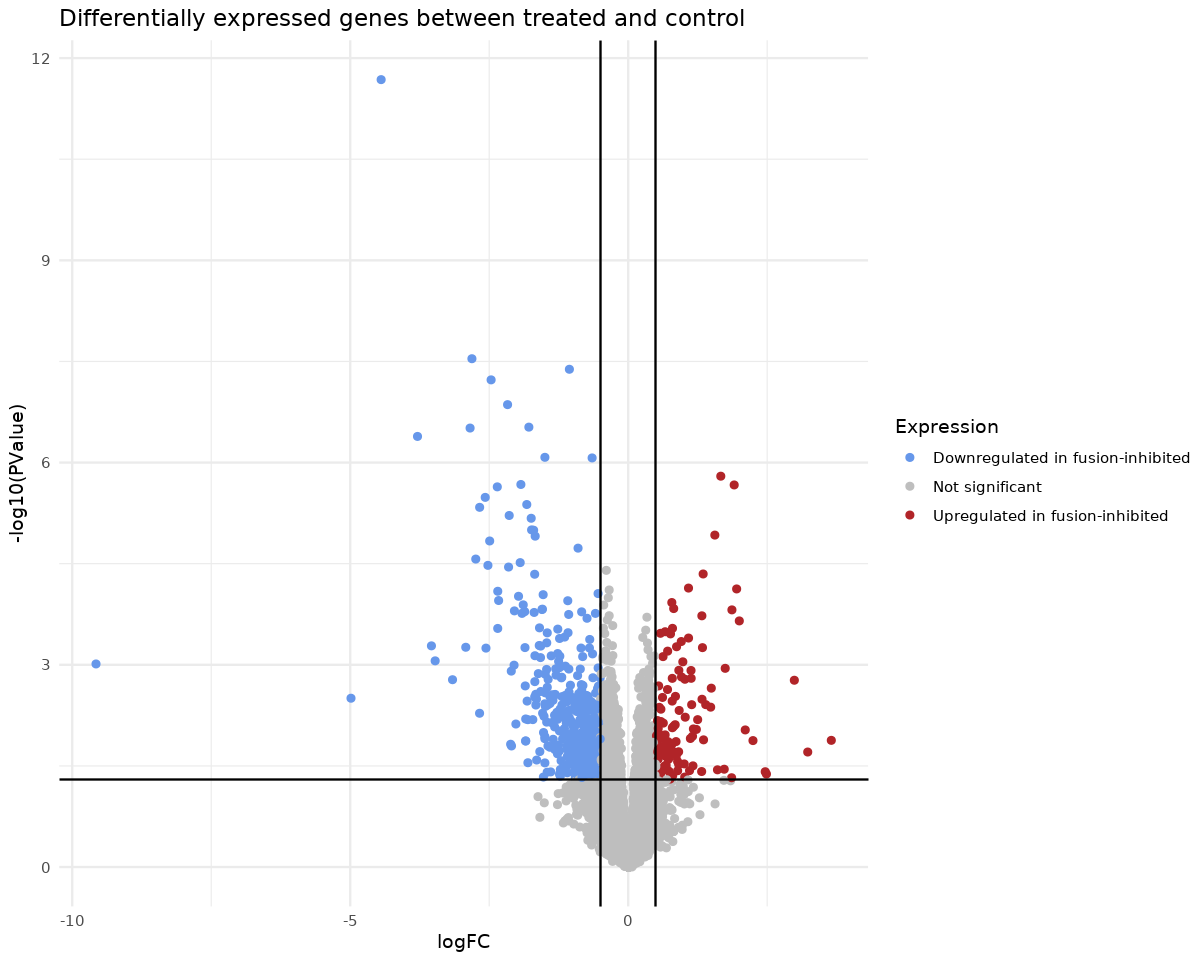

In [490]:
de_treatment= qlf$table

# add a column of NAs
de_treatment$Expression <- "Not significant"

lfc_cutoff = 0.5
p_cutoff = 0.05

de_treatment$Expression[de_treatment$logFC >= lfc_cutoff & de_treatment$PValue <= p_cutoff] <- "Upregulated in fusion-inhibited"
de_treatment$Expression[de_treatment$logFC <= -lfc_cutoff & de_treatment$PValue <= p_cutoff] <- "Downregulated in fusion-inhibited"

table(de_treatment$Expression)

ggplot(data=de_treatment, aes(x=logFC, y=-log10(PValue), col=Expression))+
  geom_point(size=1.5) + 
  theme_minimal() +
  scale_color_manual(values=c("#6697ea", "grey","#b12428")) +
  geom_vline(xintercept=c(-lfc_cutoff, lfc_cutoff), col="black") +
  geom_hline(yintercept=-log10(p_cutoff), col="black") +
  ggtitle("Differentially expressed genes between treated and control") 

Warning message:
"Removed 15710 rows containing missing values (geom_text_repel)."


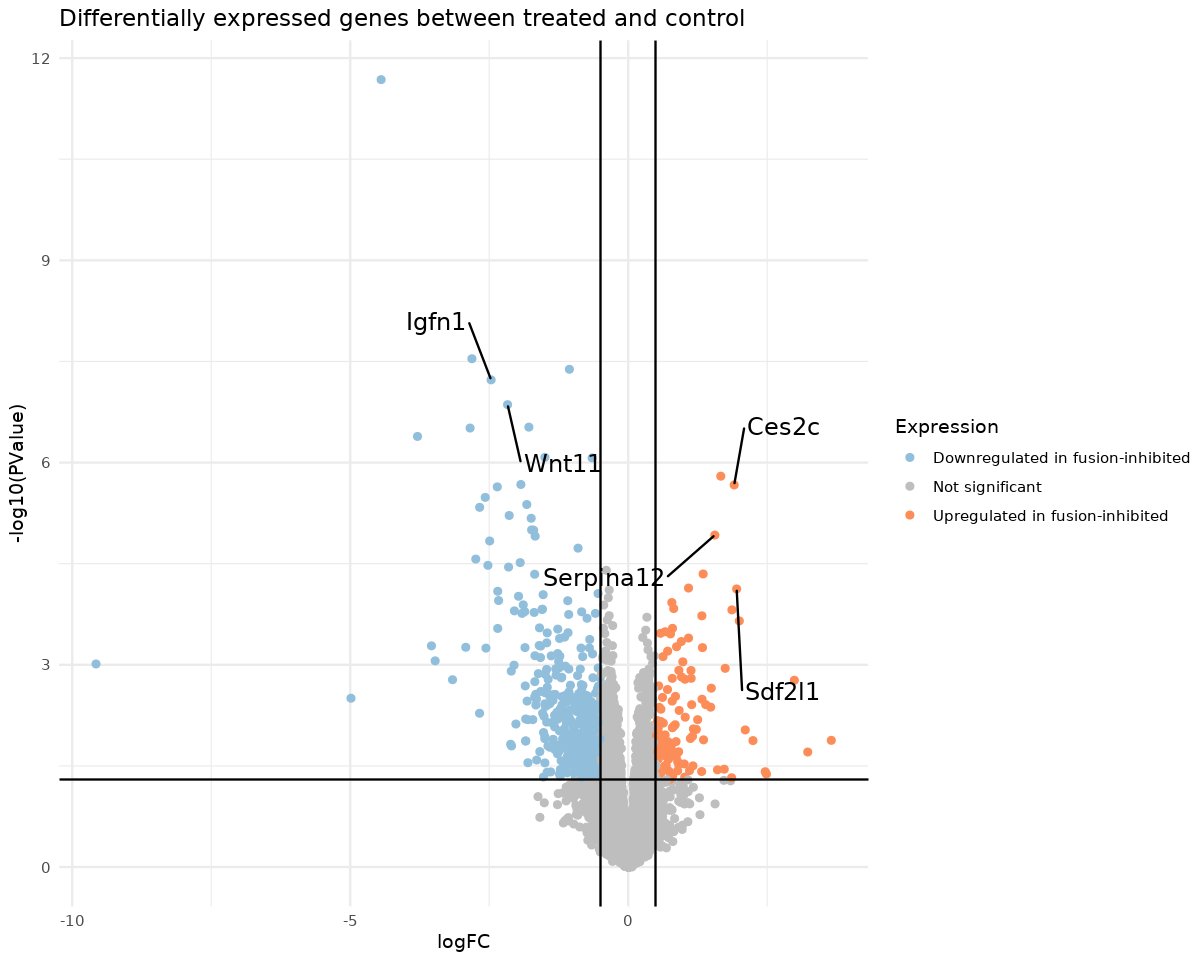

In [491]:
# Pick out some genes of interest to label, change colors
genelist = c("Wnt11","Igfn1","Ces2c","Sdf2l1","Serpina12")
de_treatment$delabel <- NA
de_treatment$delabel[which(rownames(de_treatment) %in% genelist)] <- genelist

ggplot(data=de_treatment, aes(x=logFC, y=-log10(PValue), col=Expression, label=delabel))+
  geom_point(size=1.5) + 
  theme_minimal() +
  geom_text_repel(box.padding = 2,size = 5,color="black") +
  scale_color_manual(values=c("#91bfdb", "grey","#fc8d59")) +
  geom_vline(xintercept=c(-lfc_cutoff, lfc_cutoff), col="black") +
  geom_hline(yintercept=-log10(p_cutoff), col="black") +
  ggtitle("Differentially expressed genes between treated and control")

In [488]:
# Write the DE gene lists export
write.csv(rownames(de_treatment)[de_treatment$Expression == "Upregulated in fusion-inhibited"], 
          file="c2c12_rnaseq_timecourse/deg/upreg_fusion_inhib.csv", quote=F, row.names = F)
write.csv(rownames(de_treatment)[de_treatment$Expression == "Downregulated in fusion-inhibited"], 
          file="c2c12_rnaseq_timecourse/deg/downreg_fusion_inhib.csv", quote=F, row.names = F)

## Gene ontology analysis

[Metascape](http://metascape.org/gp/index.html#/main/step1) is a quick web-based method for GO analysis. Select a file or copy paste gene IDs or gene names, select the species (C2C12 = mouse), and choose Express Analysis.

# Day 2 Goals
- Run alignment job for at least 1 sample
- Load counts/TPM matrix into R and practice matrix manipulation, subsetting, etc. 
- Practice making plots with `ggplot2`
- Identify differentially expressed genes in a dataset

# Homework
- Get comfortable in Jupyter notebook hub
- Make at least one plot using ggplot in Jupyter R notebook (check tutorial links below)
- Think about some applications of differential gene expression analysis

# Useful links
- [Intro to Jupyter notebooks](https://towardsdatascience.com/a-beginners-tutorial-to-jupyter-notebooks-1b2f8705888a)
- [ggplot tutorial](http://r-statistics.co/Complete-Ggplot2-Tutorial-Part1-With-R-Code.html)  
- [Another ggplot tutorial](https://www.publichealth.columbia.edu/sites/default/files/media/fdawg_ggplot2.html)
- [edgeR tutorial](https://web.stanford.edu/class/bios221/labs/rnaseq/lab_4_rnaseq.html)